<H2>課題5: 住宅価格の予測 (Advanced Version)</H2>
<p>課題2ではKaggleにある住宅価格予測を行いました。その際に利用したデータは、モデリングの基礎を学びやすくするために、変数の抜粋やデータの調整を施しました</p>
<p>では、調整されていない「実際のデータ」を使って解析するには、どうしたらよいでしょうか？Kaggle MasterのSerigne氏が、その方法をKaggleのサイト内で公開しています。<br>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
</p>
<p>本課題では、上記のページに書かれている内容の中から重要な部分をピックアップし、<i>dataset/kaggle_housing_price.csv</i> のデータを使って作業に取り組んでもらいます。課題を通じて「実際のデータを使って解析する際にどのような作業を行うか」について学び、今までの知識をブラッシュアップしていきましょう。CSVの各列がどういう情報かについては、以下のページの Data fields を参照してください。<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
</p>

<H2>1. 必要なモジュールの読み込み</H2>

In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

<H2>2. データの読み込み </H2>

In [2]:
# データを読み込んで変数 data に格納
data = pd.read_csv("dataset/kaggle_housing_price.csv")

In [3]:
# データの最初の5行だけ表示
aa = data[["LotFrontage","Neighborhood"]]
bb = aa[aa['LotFrontage'].isnull()]
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<H2>3. データ概要の確認</H2>
<p>そもそもt検定などを実施する場合、データに正規性と等分散性があるのか否かが重要です。等分散性がないと結果を正しく解析することができません（書籍では、等分散性を考慮しなくてもt検定が行える Welchの検定について触れています）。</p></p>
<p>正規性が確認できない場合は、何らかの **データ変換** を行い、正規性が確保できる状態にします（ただし、あらゆるデータ変換の方法を試すのはpハッキングになりかねませんので、気をつけましょう）。</p>

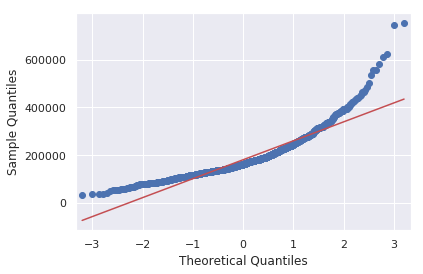

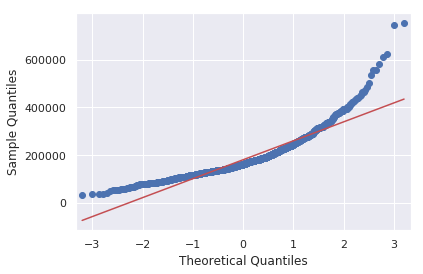

In [4]:
# Q-Qプロットを表示して正規性を確認
SalePrice = data.SalePrice
sm.qqplot(SalePrice, line = "s")

Q-Qプロットでデータの点が線上にきれいに乗っていれば、正規性は確認できます。もし、データの点が線から少し離れてしまっている（正規性が明確には確認できない）場合は、データ変換を試みます。今回は **対数変換** を行いましょう。

対数変換には、NumPyが持っている log1p を使います。NumPyの公式サイトに詳細が記載されています。<br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html

また、対数変換を行う意味については、次のページなどで調べてみてください。<br>
https://atarimae.biz/archives/13161

In [5]:
#　NumPy の log1p を用いて全てのデータの対数変換を実施　
SalePrice_log = np.log1p(data.SalePrice)

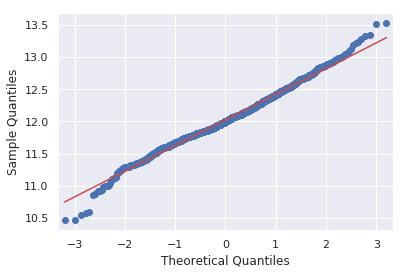

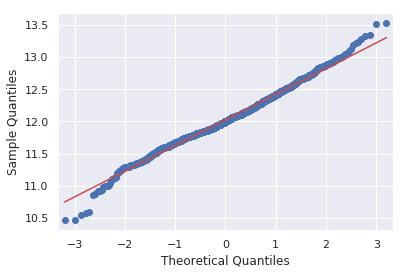

In [6]:
#　対数変換をした後のデータで再度Q-Qプロットを作成し、表示
sm.qqplot(SalePrice_log, line = "s")

対数変換しなかった場合よりも、データの点が線上にきれいに乗っているかと思います。これで正規性が確認できました。

<H2>4. 欠損値の確認と補充</H2>
<p>データセットが欠損値（空白）を含む場合、そのまま回帰分析等を行うと、エラーが発生したり、精度が悪くなったりします。</p>
<p>欠損値があまり多くない場合にはただ欠損値を含むデータを削除すればよいですが、あまりにも量が多い場合には削除してしまうとデータの多くを失ってしまうことになります。そのような場合には、**当たり障りのない値で埋める** という手法が取られます。</p>
<p><i>dataset/kaggle_housing_price.csv</i>では、欠損したデータには 'NA' という2文字が入っています。Pandasはデフォルトで 「'NA' とだけ入っているデータは欠損値である」というルールでCSVのデータを読み込んでくれますので、あとは私たちの手で欠損値（NA） をどう扱うか決めて、欠損したままにせず何らかのデータで補充する処理をしなくてはなりません。</p>
<p>なお、以下の作業では、書籍で紹介されていないPandasの関数を使います。以下の公式ドキュメントなどで調べながら取り組んでください。<br>
https://pandas.pydata.org/pandas-docs/version/0.23/api.html#dataframe
</p>

In [7]:
# 　以下の流れで、欠損値の数を調査して、表示してみましょう。
# 1. dataの各列に含まれる空白の数を調べ、割合を計算して、変数 all_data_na に格納する
n_na = data.isnull().sum()
all_data_na = n_na / data.shape[0]

# 2. all_data_na からPandasのDataFrameを作成し、変数 missing_data に格納する（割合の情報が入った列名は 'Missing_Ratio'にすること）
missing_data = pd.DataFrame({'Missing_Ratio' : all_data_na})

# 3. 空白が1つ以上ある列の情報のみを抽出して、表示
na = missing_data.query("not Missing_Ratio == 0")
na_index = list(na.index)
data[na_index]


,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
5,85.0,NaN,None,0.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,1993.0,Unf,TA,TA,NaN,MnPrv,Shed
6,75.0,NaN,Stone,186.0,Ex,TA,Av,GLQ,Unf,SBrkr,Gd,Attchd,2004.0,RFn,TA,TA,NaN,NaN,NaN
7,NaN,NaN,Stone,240.0,Gd,TA,Mn,ALQ,BLQ,SBrkr,TA,Attchd,1973.0,RFn,TA,TA,NaN,NaN,Shed
8,51.0,NaN,None,0.0,TA,TA,No,Unf,Unf,FuseF,TA,Detchd,1931.0,Unf,Fa,TA,NaN,NaN,NaN
9,50.0,NaN,None,0.0,TA,TA,No,GLQ,Unf,SBrkr,TA,Attchd,1939.0,RFn,Gd,TA,NaN,NaN,NaN


<p>次に、欠損値の補充を行います。本来なら全ての列について欠損値を埋めるべきですが、以下では2つの列についてのみ対応します。</p>
<H3>4-1. PoolQCの場合 </H3>
<p>プールが無い家の PoolQC（プールの品質） の列に NA が入っています。ですので「無いことを意味しているが欠損値として扱われないデータ」、たとえば "None" という文字列、もしくは整数の 0 で置き換えましょう。</p>

In [8]:
# PoolQCのNAを文字列 "None" で置換する
data = data.fillna({"PoolQC" : "None"})

In [9]:
# PoolQCのNAが"None"で置換されたことを確認する
data["PoolQC"] 

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
1430    None
1431    None
1432    None
1433    None
1434    None
1435    None
1436    None
1437    None
1438    None
1439    None
1440    None
1441    None
1442    None
1443    None
1444    None
1445    None
1446    None
1447    None
1448    None
1449    None
1450    None
1451    None
1452    None
1453    None
1454    None
1455    None
1456    None
1457    None
1458    None
1459    None
Name: PoolQC, Length: 1460, dtype: object

<H3>4-2. LotFrontageの場合</H3>
<p>LotFrontageは「間口の広さ（家屋の正面の幅）」です。LotFrontageが欠損している場合、どのような値を埋めれば良いでしょうか。一例としては「近隣の家々、つまり『近くの通りの名前（Neighborhood）』が同じ家々のLotFrontageの値とほぼ同じになる」という考え方です。そこで今回は、補充する値として「Neighborhoodが同じ家々のLotFrontafeの中央値（median）」を採用します。</p>

In [10]:
# Comment: こちらでNeighborhoodごとのmedianでLoftの欠損値が埋められます
#data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [11]:
data.groupby('Neighborhood').aggregate({'LotFrontage': np.median}).reset_index()

,Neighborhood,LotFrontage
0,Blmngtn,43.0
1,Blueste,24.0
2,BrDale,21.0
3,BrkSide,52.0
4,ClearCr,80.0
5,CollgCr,70.0
6,Crawfor,74.0
7,Edwards,65.5
8,Gilbert,65.0
9,IDOTRR,60.0


In [12]:
# LotFrontageのNAを、近隣の家（Neighborhood）単位でLotFrontageのmedianを取って、その値で埋める
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [13]:
# LotFrontageのNAが近隣の家々のLotFrontageのmedianで置換されたことを確認
data[["LotFrontage", "Neighborhood"]]

,LotFrontage,Neighborhood
0,65.0,CollgCr
1,80.0,Veenker
2,68.0,CollgCr
3,60.0,Crawfor
4,84.0,NoRidge
5,85.0,Mitchel
6,75.0,Somerst
7,80.0,NWAmes
8,51.0,OldTown
9,50.0,BrkSide


<H2>5. 変数の選択</H2>
<p>テキストではあまり触れられていませんでしたが、相関関係のある変数を複数、モデルに含めてしまうと、回帰係数の分散が大きくなりモデルが不安定になります。この問題を **多重共線性** と言います。多重共線性を回避するためには、あらかじめ変数同士の相関について確認し、強い相関関係にあるものは取り除く必要があります。ここではその方法について確認しましょう。</p>
<p>その手法が、Kaggle内の以下のページにまとめられています。こちらの内容を参考にしながら、下記の作業に取り組んでください。<br>
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
</p>

In [14]:
threshold = 0.8    # 相関係数が threshold に設定した数値以上だった場合、その変数を取り除く

In [15]:
# data から相関行列（Correlation Matrix）を作成して表示する。その際、絶対値を適用して負の値をプラスに変換すること
correlation_data = abs(data.corr())
correlation_data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.021917
MSSubClass,0.011156,1.000000,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.084284
LotFrontage,0.003381,0.370367,1.000000,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.349876
LotArea,0.033226,0.139781,0.335957,1.000000,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.263843
OverallQual,0.028365,0.032628,0.239546,0.105806,1.000000,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.790982
OverallCond,0.012609,0.059316,0.043595,0.005636,0.091932,1.000000,0.375983,0.073741,0.128101,0.046231,...,0.003334,0.032589,0.070356,0.025504,0.054811,0.001985,0.068777,0.003511,0.043950,0.077856
YearBuilt,0.012713,0.027850,0.120999,0.014228,0.572323,0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,0.387268,0.031355,0.050364,0.004950,0.034383,0.012398,0.013618,0.522897
YearRemodAdd,0.021998,0.040581,0.084550,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,0.193919,0.045286,0.038740,0.005829,0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.050298,0.022936,0.196825,0.104160,0.411876,0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,0.110204,0.018796,0.061466,0.011723,0.029815,0.005965,0.008201,0.477493
BsmtFinSF1,0.005024,0.069836,0.232576,0.214103,0.239666,0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,0.102303,0.026451,0.062021,0.140491,0.003571,0.015727,0.014359,0.386420


In [16]:
# 対角線上は絶対に 1 になること、および、対角線より下の部分は、上の部分と情報が重複していることから
# 相関行列を上三角行列に変換 
triangle_data = pd.DataFrame(np.triu(correlation_data, k = 1), index = correlation_data.index, columns = correlation_data.columns)
triangle_data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,0.0,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.021917
MSSubClass,0.0,0.000000,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.084284
LotFrontage,0.0,0.000000,0.000000,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.349876
LotArea,0.0,0.000000,0.000000,0.000000,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.263843
OverallQual,0.0,0.000000,0.000000,0.000000,0.000000,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.790982
OverallCond,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.375983,0.073741,0.128101,0.046231,...,0.003334,0.032589,0.070356,0.025504,0.054811,0.001985,0.068777,0.003511,0.043950,0.077856
YearBuilt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,0.387268,0.031355,0.050364,0.004950,0.034383,0.012398,0.013618,0.522897
YearRemodAdd,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179618,0.128451,...,0.205726,0.226298,0.193919,0.045286,0.038740,0.005829,0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264736,...,0.159718,0.125703,0.110204,0.018796,0.061466,0.011723,0.029815,0.005965,0.008201,0.477493
BsmtFinSF1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.204306,0.111761,0.102303,0.026451,0.062021,0.140491,0.003571,0.015727,0.014359,0.386420


In [17]:
# 上三角行列から SalePrice以外の列について threshold 以上の値が1つ以上ある列を抽出。その「削除すべき変数」の名前および総数を表示する
# （→これを除去すべき変数と判断します）
to_drop = [column for column in triangle_data.columns if column != 'SalePrice' if any(triangle_data[column] > threshold)]

print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
削除する変数の数： 4


In [18]:
# data から削除する変数を削除して data_dropped に格納し、data_dropped の内容を表示する
data_dropped = data.drop(columns = to_drop)
data_dropped.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,12,2008,WD,Normal,250000


<H2>6. ダミー変数化</H2>
<p>カテゴリ変数は **ダミー変数化** する必要があります。ダミー変数の説明は、書籍では第5章の第2部（分散分析） 2-14で書かれていますので、そちらをご確認ください。</p>
<p>ひとつ例を出して説明します。たとえば、「Weather」という列があり、そこに入っているデータが、</p>

- 'Sunny'（晴れ）
- 'Cloudy'（くもり）
- 'Rainy'（雨）

<p>以上の3種類の文字列のみで構成されているとします。このとき「Weather」を、以下のような内容の3つの列に分割します。</p>

- Weather_Sunny：元の Weather のデータが 'Sunny' なら整数値の 1 が、それ以外なら整数値の 0 が入る
- Weather_Cloudy：元の Weather のデータが 'Cloudy' なら整数値の 1 が、それ以外なら整数値の 0 が入る
- Weather_Rainy：元の Weather のデータが 'Rainy' なら整数値の 1 が、それ以外なら整数値の 0 が入る

<p>このような作業がダミー変数化です。</p>

In [19]:
# data_dropped に含まれる全てのカテゴリ変数をダミー変数化して data_dummied に格納する。ダミー変数化には Pandas の関数を実行すること。
# （ひとつずつダミー変数化しても良いですが、ここでは一気に全てダミー変数化する命令を使います）
data_dummied = pd.get_dummies(data_dropped)   

In [20]:
# ダミー変数化されたことを確認
data_dummied

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
7,8,60,80.0,10382,7,6,1973,1973,240.0,859,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,0,0,1,0,0,0,0,1,0


<p>ここまで、読み込んだデータに対して「データの対数変換」「欠損値の補充」「多重共線性の回避」「ダミー変数化」の作業を行いました。このような作業を通したデータを分類や予測にかけると、精度の良い結果が得られます。</p>
<p>本課題としての必須項目は、ここまでです。お疲れ様でした！</p>
<p>もし余裕がある場合は、以下の（任意）の内容について取り組みましょう。</p>

<H2>7. （任意）住宅価格の予測の実行</H2>
<p>せっかくなので、得られたデータを予測にかけてみましょう。</p>

<h3>7-1. さらなる欠損値の補充</h3>
<p>上記では、欠損値の補充を2種類（PoolQC と LotFrontage）しか行いませんでした。まずは、変数 data に対してさらなる欠損値の補充を行いましょう。</p>

In [21]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# 上記ページの内容を参考に、data に入っているデータのうち、
# 既に補充している PoolQC と LotFrontage 以外の列について、補充すべき欠損値を補充する
data["MasVnrArea"] = data["MasVnrArea"].fillna(data["MasVnrArea"].median())
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(data["GarageYrBlt"].median())
data = data.fillna("None")

<h3>7-2. 変数の選択とダミー変数化を再度実施する</h3>

In [22]:
threshold = 0.8    # 相関係数が threshold に設定した数値以上だった場合、その変数を取り除く

In [23]:
# data から相関行列（Correlation Matrix）を作成する。その際、絶対値を適用して負の値をプラスに変換すること
correlation_data = abs(data.corr())

In [24]:
# 相関行列を上三角行列に変換 
triangle_data = pd.DataFrame(np.triu(correlation_data, k = 1), index = correlation_data.index, columns = correlation_data.columns)

In [25]:
# 「削除すべき変数」の名前および総数を表示する
to_drop = [column for column in triangle_data.columns if column != 'SalePrice' if any(triangle_data[column] > threshold)]
print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']
削除する変数の数： 3


In [26]:
# data から削除する変数を削除して data_dropped に格納し、data_dropped の内容を表示する
data_dropped = data.drop(columns = to_drop)
data_dropped

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,80.0,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [27]:
# data_dropped に含まれる全てのカテゴリ変数をダミー変数化して data_dummied に格納し、表示
data_dummied = pd.get_dummies(data_dropped)
data_dummied

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
7,8,60,80.0,10382,7,6,1973,1973,240.0,859,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,0,0,1,0,0,0,0,1,0


<H3>7-3. データを訓練データとテストデータに分割</H3>

In [28]:
from sklearn.model_selection import train_test_split    # 必要なモジュールの読み込み

In [29]:
# 説明変数 X を用意する。ただし id列, SalePrice列は除去する
X = data_dummied.drop(['Id', 'SalePrice'], axis=1)
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,0,0,0,1,0,0,0,0,1,0
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,0,0,0,1,0,0,0,0,1,0
7,60,80.0,10382,7,6,1973,1973,240.0,859,32,...,0,0,0,1,0,0,0,0,1,0
8,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,0,0,1,0,0,0,0,1,0


In [30]:
# 応答変数 y は SalePrice 列だけのデータで用意する
y = pd.DataFrame(data_dummied['SalePrice'])
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


In [31]:
# X、y を訓練データ (X_train, y_train) とテストデータ (X_test, y_test) に分ける
X_train, X_test, y_train ,y_test = train_test_split(X, y, random_state = 2)

<H3>7-4. 重回帰分析</H3>

In [32]:
from sklearn import linear_model    # 必要なモジュールの読み込み

In [33]:
# Ridge回帰モデルを作成して予測を実行する
# 1. alphaを50個つくる
n_alphas = 50
ridge_alphas = np.logspace(-2, 0.7, n_alphas)
ridge_coefs = []
for a in ridge_alphas:
    ridge = linear_model.Ridge(alpha = a, fit_intercept = False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs)
# 2. RidgeCVを使って最適なalphaでモデルを構築する
ridge_best = linear_model.RidgeCV(
    cv = 10, alphas = ridge_alphas, fit_intercept = False)
ridge_best.fit(X, y) 
# 3. 訓練データを指定してモデルを推定する
ridge_best.coef_

array([[-1.20631815e+02, -1.40495710e+02,  5.04020065e-01,
         8.69754923e+03,  5.03672289e+03,  1.91481514e+02,
         6.53888984e+01,  1.77418133e+01,  7.84649564e-01,
         4.37266480e+00, -1.83737194e+00,  3.31993189e+00,
         1.26273907e+01, -2.23115129e+01,  5.02646445e+01,
         5.74590595e+03,  5.04600280e+02,  6.75363517e+03,
         2.78058127e+03, -1.28345130e+03, -8.08779225e+03,
         4.27152126e+03, -4.77301770e+01,  1.21875246e+04,
         1.92856239e+01, -1.77647061e+00,  8.43814006e+00,
         4.24921352e+01,  4.18469617e+01,  6.02606304e+01,
         1.34411575e-01, -3.63039492e+02, -2.39231105e+02,
        -1.40696568e+04,  8.38789368e+03,  2.14609777e+03,
         4.65969587e+03, -1.05884801e+03, -8.61405102e+03,
         8.67923350e+03,  8.21546951e+02,  3.92273280e+02,
        -1.14863775e+03,  1.69734144e+03,  7.30150735e+03,
        -1.13280676e+04,  2.39440132e+03, -1.02492861e+04,
         7.66138555e+03, -2.05714050e+03,  4.71022356e+0

In [40]:
y_pred = ridge.predict(X_test)

In [46]:
sum((y_pred - np.array(y_test))**2)/len(y_pred)

array([9.00677758e+08])

In [48]:
9.00677758e+08**(1/2)

30011.293840819326

In [39]:
len(y_pred)

1095

In [34]:
# 訓練データの的中率を表示
from sklearn.neural_network import MLPClassifier

nnet = MLPClassifier(
    hidden_layer_sizes = (100,100),
    alpha = ridge_alphas)

nnet.fit(X_train, y_train)

print("訓練データの的中率　：", nnet.score(X_train, y_train))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# テストデータの的中率を表示
nnet.fit(X_test, y_test)
print("テストデータの的中率：", nnet.score(X_test, y_test))
MSE

In [ ]:
for i in range(20):
    if i%3==0:
        print('Fizz')
    elif i%5==0:
        print('Buzz')
    else:
        print(i)

In [ ]:
["FizzBuzz" if i % 15 == 0 else "Fizz" if i % 3 == 0 else "Buzz" if i % 5 == 0 else i for i in range(1, 101)]